In [59]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [60]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [61]:
len(words)

32033

In [62]:
chars = sorted(list(set(''.join(words))))
charIntIndexMapping = {s:i+1 for i,s in enumerate(chars)}
charIntIndexMapping['.'] = 0
indexToCharMapping ={i:s for s,i in charIntIndexMapping.items()}

In [63]:
#1. Build the dataset: Train, Validation and Test
block_size = 3 

def build_dataset(words):  

    block_size = 3 
    inputContext, outputCharcterForThatContext = [], []
    
    for w in words:
      
    
      contextSlidingWindow = [0] * block_size
        
      for ch in w + '.': 
        index = charIntIndexMapping[ch]
        inputContext.append(contextSlidingWindow)
        outputCharcterForThatContext.append(index)
    #print(''.join(indexToCharMapping[i] for i in context), '--->', indexToCharMapping[ix])
        contextSlidingWindow = contextSlidingWindow[1:] + [index]

    inputContext = torch.tensor(inputContext)
    outputCharcterForThatContext = torch.tensor(outputCharcterForThatContext)
    print(inputContext.shape,outputCharcterForThatContext.shape)
    return inputContext,outputCharcterForThatContext

import random
random.seed(42)
random.shuffle(words)
noOfWordForTraining = int(0.8*len(words))
noOfWordsForValidation = int(0.9*len(words))

inputContextTrain, outputCharacterTrain = build_dataset(words[:noOfWordForTraining])
inputContextValidation, outputCharacterValidation = build_dataset(words[noOfWordForTraining:noOfWordsForValidation])
inputContextTesting, outputCharacterTesting = build_dataset(words[noOfWordsForValidation:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [64]:
#2. MLP revisited: Creating Parameters for MLP(Charembedding, Weights and biases)

n_embd = 2 # the dimensionality of the character embedding vectors
n_hidden = 300 # the number of neurons in the hidden layer of the MLP(1st layer)
vocab_size=27 #unique characters we have including '.'

g = torch.Generator().manual_seed(2147483647) # for reproducibility
charEmbeddings  = torch.randn((vocab_size, n_embd),generator=g,requires_grad=True)
weightLayer1 = torch.randn((n_embd * block_size, n_hidden), generator=g,requires_grad=True)
biasLayer1 = torch.randn(n_hidden,generator=g,requires_grad=True)
weightLayer2 = torch.randn((n_hidden, vocab_size),generator=g,requires_grad=True)
biasLayer2 = torch.randn(vocab_size,generator=g,requires_grad=True)

parameters = [charEmbeddings, weightLayer1, weightLayer2, biasLayer1, biasLayer2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

10281


In [65]:
#3. Training the model
max_steps=200000
batch_size=32
lossi = []
stepsi = []
noOfColAfterFlattening = block_size*n_embd
for i in range(max_steps):
    noOfWindowsToBeUsedPerLearningStep = batch_size
    randomSlidingWindowsUsed = torch.randint(0, inputContextTrain.shape[0], (noOfWindowsToBeUsedPerLearningStep,))
    inputForLayer1 = charEmbeddings[inputContextTrain[randomSlidingWindowsUsed]]
    inputForLayer1 = inputForLayer1.view(noOfWindowsToBeUsedPerLearningStep, noOfColAfterFlattening)
    h = torch.tanh(inputForLayer1@weightLayer1+biasLayer1)
    logits = h@weightLayer2+biasLayer2
    loss = F.cross_entropy(logits,outputCharacterTrain[randomSlidingWindowsUsed])
    for p in parameters:
        p.grad = None 
    loss.backward()
    for p in parameters:
        p.data += -0.1*p.grad 
    #track stats    
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}') #logging the loss in every 10,000 learning steps 
    lossi.append(loss.item())
    stepsi.append(i)

   

print("loss on training data set",loss.item())

      0/ 200000: 32.3287
  10000/ 200000: 2.8042
  20000/ 200000: 3.8063
  30000/ 200000: 2.8232
  40000/ 200000: 2.7013
  50000/ 200000: 2.7911
  60000/ 200000: 2.2672
  70000/ 200000: 2.2274
  80000/ 200000: 2.3607
  90000/ 200000: 2.7010
 100000/ 200000: 2.5281
 110000/ 200000: 2.9446
 120000/ 200000: 2.5187
 130000/ 200000: 2.0874
 140000/ 200000: 1.7350
 150000/ 200000: 2.5241
 160000/ 200000: 1.9589
 170000/ 200000: 2.8559
 180000/ 200000: 2.3065
 190000/ 200000: 2.1971
loss on training data set 1.882584810256958


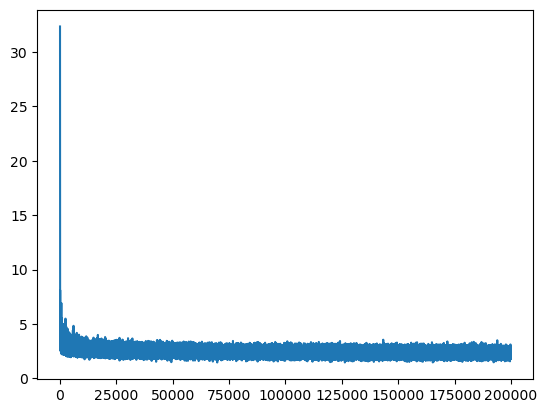

In [66]:
plt.plot(stepsi,lossi)

In [132]:
def trainingModel(inputContextTrain,charEmbeddings,weightLayer1,biasLayer1,weightLayer2,biasLayer2):
    max_steps=200000
    batch_size=32
    lossi = []
    stepsi = []
    parameters = [charEmbeddings, weightLayer1, weightLayer2, biasLayer1, biasLayer2]
    noOfColAfterFlattening = block_size*n_embd
    for i in range(max_steps):
        noOfWindowsToBeUsedPerLearningStep = batch_size
        randomSlidingWindowsUsed = torch.randint(0, inputContextTrain.shape[0], (noOfWindowsToBeUsedPerLearningStep,))
        inputForLayer1 = charEmbeddings[inputContextTrain[randomSlidingWindowsUsed]]
        inputForLayer1 = inputForLayer1.view(noOfWindowsToBeUsedPerLearningStep, noOfColAfterFlattening)
        h = torch.tanh(inputForLayer1@weightLayer1+biasLayer1)
        logits = h@weightLayer2+biasLayer2
        loss = F.cross_entropy(logits,outputCharacterTrain[randomSlidingWindowsUsed])
        for p in parameters:
            p.grad = None 
        loss.backward()
        lr = 0.1 if i<100000 else 0.01
        for p in parameters:
            p.data += -lr * p.grad 
        #track stats    
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}') #logging the loss in every 10,000 learning steps 
        lossi.append(loss.item())
        stepsi.append(i)
    
       
    
    print("loss on training data set",loss.item())

In [133]:
#4 Problems with our neural net so far

#1.LOSS FOR FIRST LEARNING STEP IS TOO HIGH
    #a. For the first learning step the loss is too high i.e 24.25, as seen from graph in next leanring steps it goes down drastically which
    #suggests that something is wrong with our parameters with which we start with

    #b. so we have 27 character possible for any place and in starting when our model is not trained every character should 
    #be equally likely so prob for any character to come at a place is 1/27 and we do negative log likelihood which is 3.29
    # and since loss is basically mean so our loss to start with is 3.29 and not 24.25 this suggests something is wrong
    #with our model to params with which we start with

#2. SOLUTION:
    #a. We want for the first learning step logits to have value closer to each other the more wide i.e different the logit value are
    #the less equilikely will be prob of occurences and hence the more will be loss (i.e more bigger than 3.29 loss which is for equilikely)
    #b. We want logits[i][j] to have equal like values, so we want logits[i][j] to have value closer to 0
    #c. We make b2(bias for layer-2) to be 0 start with Weights for layer to be multiplied by 0.1


g = torch.Generator().manual_seed(2147483647) # for reproducibility
charEmbeddings  = torch.randn((vocab_size, n_embd),generator=g,requires_grad=True)
weightLayer1 = torch.randn((n_embd * block_size, n_hidden), generator=g,requires_grad=True)
biasLayer1 = torch.randn(n_hidden,generator=g,requires_grad=True)
weightLayer2 = torch.randn((n_hidden, vocab_size),generator=g)*0.1
biasLayer2 = torch.randn(vocab_size,generator=g)*0

weightLayer2.requires_grad=True
biasLayer2.requires_grad=True

#weightLayer2 = torch.randn((n_hidden, vocab_size),generator=g, required_grad=True)*0.1 was causing error when we were multiplyinh
#learning rate with gradient, Error was cant multiply none with fload hence separated out requires_grad=true in separate line

parameters = [charEmbeddings, weightLayer1, weightLayer2, biasLayer1, biasLayer2]
trainingModel(inputContextTrain,charEmbeddings,weightLayer1,biasLayer1,weightLayer2,biasLayer2)


#3. Observations from Solution:
    #1. Loss for first step drastically reduces from very big value like 32 to 3.9 which we want, because equilikely prob=3.29

      0/ 200000: 3.9170
  10000/ 200000: 2.6981
  20000/ 200000: 2.3821
  30000/ 200000: 2.3894
  40000/ 200000: 2.9963
  50000/ 200000: 1.9845
  60000/ 200000: 2.1812
  70000/ 200000: 2.2354
  80000/ 200000: 1.6948
  90000/ 200000: 2.0942
 100000/ 200000: 2.5399
 110000/ 200000: 2.1137
 120000/ 200000: 1.9388
 130000/ 200000: 2.2482
 140000/ 200000: 2.0150
 150000/ 200000: 2.1110
 160000/ 200000: 2.2486
 170000/ 200000: 2.3297
 180000/ 200000: 2.1560
 190000/ 200000: 1.7352
loss on training data set 2.2289323806762695
